<a href="https://colab.research.google.com/github/vinodkraman/Learning-Permutations/blob/main/LearningPermutations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Sun Dec  1 03:15:53 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import collections

In [ ]:
def shuffle_columns(tensor, indices):
    return tensor[:, indices]

In [ ]:
N = 10 # Sequence length
vocab_size = 10 #vocab_size
batch_size = 1000 #batch size

n_train = 3000 #training set size
n_test = 1000 #validation set

A = torch.eye(N).long()

perm = torch.randperm(N)
A = shuffle_columns(A, perm) #generates a random permutation matrix
print(A)

tensor([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]])


In [ ]:
# Generate a batch of random input sequences
input_sequences = torch.randint(0, vocab_size, (n_train, N)) #n x N
output_sequences  = torch.matmul(input_sequences, A)
print(torch.max(output_sequences))

train_input_sequences = input_sequences.to(device)
train_output_sequences = output_sequences.to(device)
train_dataset = torch.utils.data.TensorDataset(train_input_sequences, train_output_sequences)
train_data_loader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
    )

tensor(9)


In [ ]:
val_input_sequences = torch.randint(0, vocab_size, (n_test, N))
val_output_sequences = torch.matmul(val_input_sequences, A)

val_input_sequences = val_input_sequences.to(device)
val_output_sequences = val_output_sequences.to(device)

val_dataset = torch.utils.data.TensorDataset(val_input_sequences, val_output_sequences)
val_data_loader = torch.utils.data.DataLoader(
        dataset=val_dataset,
        batch_size=batch_size,
    )

In [ ]:
class PointwiseFeedforwardNetwork(nn.Module):
  def __init__(self, d_embed, d_ff):
    super(PointwiseFeedforwardNetwork, self).__init__()
    self.d_embed = d_embed
    self.d_ff = d_ff

    self.ffn1 = nn.Linear(d_embed, d_ff)
    self.ffn2 = nn.Linear(d_ff, d_embed)

    self.relu = nn.ReLU()

  def forward(self, x):
    return self.ffn2(self.relu(self.ffn1(x)))

In [ ]:
class Attention(nn.Module):
  def __init__(self, d_embed):
    super(Attention, self).__init__()

    self.d_embed = d_embed
    self.query_proj = nn.Linear(d_embed, d_embed).to(device)
    self.key_proj = nn.Linear(d_embed, d_embed).to(device)
    self.value_proj = nn.Linear(d_embed, d_embed).to(device)


  def forward(self, x):
    Q = self.query_proj(x)
    K = self.key_proj(x)
    V = self.value_proj(x)

    scores = torch.matmul(Q, K.transpose(2, 1)) / (self.d_embed ** 0.5)

    attention_weights = torch.softmax(scores, dim=-1)

    output = torch.matmul(attention_weights, V)

    return output


In [ ]:
class TransformerLayer(nn.Module):
  def __init__(self, d_embed, d_ff):
    super(TransformerLayer, self).__init__()
    self.d_embed = d_embed
    self.d_ff = d_ff

    self.attn = Attention(self.d_embed)

    self.norm1 = nn.LayerNorm(d_embed).to(device)
    self.norm2 = nn.LayerNorm(d_embed).to(device)
    self.dropout = nn.Dropout(0.1)

    self.ffn = PointwiseFeedforwardNetwork(d_embed, d_ff).to(device)
    self.ffout = nn.Linear(d_embed, d_embed).to(device)

  def forward(self, x):
    x = self.norm1(x + self.dropout(self.attn(x)))
    ffn = self.ffn(x)
    x = self.norm2(x + self.dropout(ffn))

    return self.ffout(x)


In [ ]:
class MultiLayerTransformer(nn.Module):
  def __init__(self, d_embed, vocab_size, d_ff, num_layers):
    super(MultiLayerTransformer, self).__init__()
    self.embed = nn.Embedding(vocab_size, d_embed).to(device)
    self.layers = nn.ModuleList([TransformerLayer(d_embed, d_ff)] * num_layers)
    self.fcout = nn.Linear(d_embed, vocab_size).to(device)

  def forward(self, x):
    x_embed = self.embed(x)

    for layer in self.layers:
      x_embed = layer(x_embed)

    return self.fcout(x_embed)

In [ ]:
class RNN(nn.Module):
  def __init__(self, d_embed, vocab_size, hidden_dim, num_layers, batch_size):
    super().__init__()
    self.size_vocab = vocab_size
    self.d_embed = d_embed
    self.hidden_dim = hidden_dim
    self.h0 = torch.zeros(num_layers, batch_size, self.hidden_dim).to(device)

    self.embed = nn.Embedding(vocab_size, d_embed).to(device)
    self.rnn = nn.RNN(d_embed, hidden_dim, num_layers= num_layers, nonlinearity='relu', dropout=0.1, batch_first=True).to(device)
    self.fc = nn.Linear(hidden_dim, vocab_size).to(device)

  def forward(self, x):
    x_embed = self.embed(x) # (n, N, embed_dim)
    x_rnn, _ = self.rnn(x_embed, self.h0) # (n, N, hidden_dim)
    out = self.fc(x_rnn) # (n, N, size_vocab)
    return out

In [ ]:
def train_epoch(data_loader, vocab_size, model, criterion, optimizer, device):
  model.train()
  epoch_losses = []

  for batch in data_loader:
    optimizer.zero_grad()
    X_train = batch[0]
    y_train = batch[1]

    outputs = model(X_train)
    loss = criterion(outputs.contiguous().view(-1, vocab_size), y_train.contiguous().view(-1))
    epoch_losses.append(loss.item())

    loss.backward()
    optimizer.step()

  return np.mean(epoch_losses)

In [ ]:
def epoch_evaluate(data_loader, vocab_size, model, criterion, device):
    model.eval()
    epoch_losses = []
    with torch.no_grad():
        for batch in data_loader:
          X_val = batch[0]
          y_val = batch[1]

          predictions = model(X_val).to(device)
          loss = criterion(predictions.contiguous().view(-1, vocab_size), y_val.contiguous().view(-1))

          epoch_losses.append(loss.item())

    return np.mean(epoch_losses)

In [ ]:
def train(vocab_size, model, criterion, optimizer, n_epochs, train_data_loader, val_data_loader):
  metrics = collections.defaultdict(list)

  for epoch in range(n_epochs):
      train_loss = train_epoch(
          train_data_loader, vocab_size, model, criterion, optimizer, device
      )
      valid_loss = epoch_evaluate(val_data_loader, vocab_size, model, criterion, device)
      metrics["valid_losses"].append(valid_loss)
      metrics["train_losses"].append(train_loss)

      if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{n_epochs}], Training loss: {train_loss:.4f}, Validation loss: {valid_loss:.4f}')

  return metrics

In [ ]:
d_ff = 32
d_embed = 32
num_layers = 3
n_epochs = 1000


trans = MultiLayerTransformer(d_embed, vocab_size, d_ff, num_layers).to(device)
optimizer_trans = torch.optim.Adam(trans.parameters())
num_trainable_params = sum([p.numel() for p in trans.parameters()])
print("# param Transformer:", num_trainable_params)

rnn = RNN(d_embed, vocab_size, d_ff, num_layers, batch_size).to(device)
optimizer_rnn = torch.optim.Adam(rnn.parameters())
num_trainable_params = sum([p.numel() for p in rnn.parameters()])
print("# param RNN:", num_trainable_params)

criterion = nn.CrossEntropyLoss().to(device)


# param Transformer: 7114
# param RNN: 6986


In [ ]:
trans_metrics = train(vocab_size, trans, criterion, optimizer_trans, n_epochs, train_data_loader, val_data_loader)

Epoch [10/1000], Training loss: 2.1891, Validation loss: 2.1676
Epoch [20/1000], Training loss: 2.0628, Validation loss: 2.0422
Epoch [30/1000], Training loss: 1.9749, Validation loss: 1.9542
Epoch [40/1000], Training loss: 1.9053, Validation loss: 1.8836
Epoch [50/1000], Training loss: 1.8836, Validation loss: 1.8622
Epoch [60/1000], Training loss: 1.8702, Validation loss: 1.8499
Epoch [70/1000], Training loss: 1.8587, Validation loss: 1.8400
Epoch [80/1000], Training loss: 1.8508, Validation loss: 1.8323
Epoch [90/1000], Training loss: 1.8440, Validation loss: 1.8260
Epoch [100/1000], Training loss: 1.8403, Validation loss: 1.8209
Epoch [110/1000], Training loss: 1.8353, Validation loss: 1.8166
Epoch [120/1000], Training loss: 1.8300, Validation loss: 1.8125
Epoch [130/1000], Training loss: 1.8273, Validation loss: 1.8098
Epoch [140/1000], Training loss: 1.8220, Validation loss: 1.8062
Epoch [150/1000], Training loss: 1.8163, Validation loss: 1.8040
Epoch [160/1000], Training loss: 1

In [ ]:
criterion = nn.CrossEntropyLoss().to(device)
rnn_metrics = train(vocab_size, rnn, criterion, optimizer_rnn, n_epochs, train_data_loader, val_data_loader)

Epoch [10/1000], Training loss: 2.2670, Validation loss: 2.2571
Epoch [20/1000], Training loss: 2.1908, Validation loss: 2.1669
Epoch [30/1000], Training loss: 2.1486, Validation loss: 2.1208
Epoch [40/1000], Training loss: 2.1208, Validation loss: 2.0933
Epoch [50/1000], Training loss: 2.0999, Validation loss: 2.0691
Epoch [60/1000], Training loss: 2.0746, Validation loss: 2.0439
Epoch [70/1000], Training loss: 2.0509, Validation loss: 2.0217
Epoch [80/1000], Training loss: 2.0329, Validation loss: 1.9951
Epoch [90/1000], Training loss: 2.0057, Validation loss: 1.9632
Epoch [100/1000], Training loss: 1.9831, Validation loss: 1.9350
Epoch [110/1000], Training loss: 1.9612, Validation loss: 1.9075
Epoch [120/1000], Training loss: 1.9422, Validation loss: 1.8831
Epoch [130/1000], Training loss: 1.9204, Validation loss: 1.8550
Epoch [140/1000], Training loss: 1.8967, Validation loss: 1.8309
Epoch [150/1000], Training loss: 1.8783, Validation loss: 1.8060
Epoch [160/1000], Training loss: 1

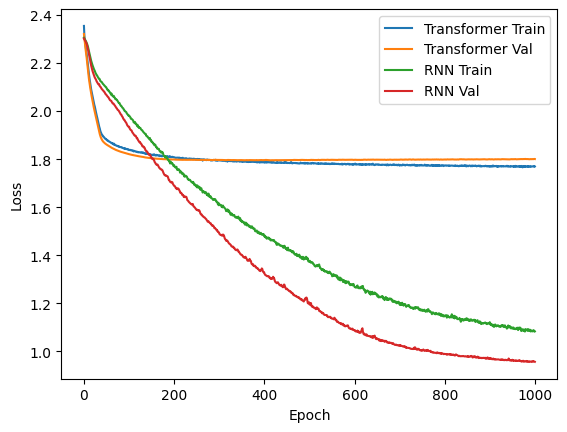

In [ ]:
import matplotlib.pyplot as plt

plt.plot(trans_metrics["train_losses"], label= "Transformer Train")
plt.plot(trans_metrics["valid_losses"], label= "Transformer Val")
plt.plot(rnn_metrics["train_losses"], label = "RNN Train")
plt.plot(rnn_metrics["valid_losses"], label = "RNN Val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()